# Mapeamento de cobertura vegetal - Variação percentual do NDVI (Natural Displacement Vegetation Index)

### Variação percentual prevista de NDVI entre 2023 e 2027
Este notebook carrega imagens NDVI, treina um modelo Prophet para fazer previsões de séries temporais, e exibe as imagens e previsões em mapas interativos usando a biblioteca **Folium**. Gera a media anual de NDVI para Angola usando os registros de **2000** a **2022** e salva em um arquivos CSV. 

In [6]:
import ee
import geemap
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster, HeatMap
import branca.colormap as cm
import requests
import io

# Trigger the authentication flow

ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-edmaurogoma2000')

In [7]:

# Definir as variáveis
region = [12, -18, 24, -4]  # Coordenadas aproximadas de Angola [oeste, sul, leste, norte]
collection = 'MODIS/006/MOD44B'  # Nome da coleção de imagens MODIS
date_range = ['2000-03-05', '2020-03-05']  # Intervalo de datas para filtrar as imagens

# Criar uma geometria do Earth Engine a partir das coordenadas
geometry = ee.geometry.Geometry.Rectangle(region)

# Criar uma coleção de imagens MODIS
dataset = (ee.ImageCollection(collection)
           .filterBounds(geometry)
           .filterDate(date_range[0], date_range[1]))

# Função para adicionar uma banda de timestamp a cada imagem
def add_timestamp(image):
    return image.addBands(image.metadata('system:time_start').rename('timestamp'))

# Mapear a função sobre a coleção de imagens
dataset_with_timestamp = dataset.map(add_timestamp)

# Obter o tamanho da coleção
collection_size = dataset_with_timestamp.size().getInfo()
print(f"Número de imagens na coleção: {collection_size}")

# Definir uma função para exportar uma imagem
def export_image(image, filename):
    task = ee.batch.Export.image.toDrive(
        image=image.select(['Percent_Tree_Cover']),  # Selecionar apenas a banda de interesse
        description=filename,
        folder='Angola_MODIS_Images',
        fileNamePrefix=filename,
        scale=500,
        region=geometry,
        maxPixels=1e9,
        fileFormat='GeoTIFF',
        formatOptions={'cloudOptimized': True}
    )
    task.start()
    return task

# Exportar imagens (limite de 5 para demonstração)
tasks = []
for i in range(min(20, collection_size)):
    image = ee.Image(dataset_with_timestamp.toList(20).get(i))
    filename = f'angola_modis_{i:03d}'
    task = export_image(image, filename)
    tasks.append(task)
    print(f"Tarefa de exportação iniciada para {filename}")

# Monitorar o status das tarefas
while tasks:
    for task in tasks[:]:  # Iterar sobre uma cópia da lista
        status = task.status()['state']
        if status == 'COMPLETED':
            print(f"Tarefa {task.status()['description']} concluída com sucesso.")
            tasks.remove(task)
        elif status == 'FAILED':
            print(f"Tarefa {task.status()['description']} falhou. Erro: {task.status()['error_message']}")
            tasks.remove(task)
        else:
            print(f"Tarefa {task.status()['description']} ainda em andamento. Status: {status}")

    if tasks:
        print("Aguardando 30 segundos antes de verificar novamente...")
        time.sleep(30)

print("Todas as tarefas de exportação foram concluídas. Verifique a pasta 'Angola_MODIS_Images' no seu Google Drive.")

# Opcional: Exibir a primeira imagem em um mapa
Map = geemap.Map()
Map.centerObject(geometry, 6)
Map.addLayer(ee.Image(dataset_with_timestamp.first()).select(['Percent_Tree_Cover']),
             {'min': 0, 'max': 100, 'palette': ['white', 'green']}, 'Cobertura Arbórea')
Map.addLayer(geometry, {'color': 'FF0000'}, 'Região de Interesse')
display(Map)

Número de imagens na coleção: 20
Tarefa de exportação iniciada para angola_modis_000
Tarefa de exportação iniciada para angola_modis_001
Tarefa de exportação iniciada para angola_modis_002
Tarefa de exportação iniciada para angola_modis_003
Tarefa de exportação iniciada para angola_modis_004
Tarefa de exportação iniciada para angola_modis_005
Tarefa de exportação iniciada para angola_modis_006
Tarefa de exportação iniciada para angola_modis_007
Tarefa de exportação iniciada para angola_modis_008
Tarefa de exportação iniciada para angola_modis_009
Tarefa de exportação iniciada para angola_modis_010
Tarefa de exportação iniciada para angola_modis_011
Tarefa de exportação iniciada para angola_modis_012
Tarefa de exportação iniciada para angola_modis_013
Tarefa de exportação iniciada para angola_modis_014
Tarefa de exportação iniciada para angola_modis_015
Tarefa de exportação iniciada para angola_modis_016
Tarefa de exportação iniciada para angola_modis_017
Tarefa de exportação iniciada p

Map(center=[-11.001728586991723, 18.00000000000003], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
# Definir a geometria de Angola
angola = ee.featurecollection.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Angola'))

# Definir o intervalo de tempo para a análise
start_year = 2000
end_year = 2023

# Função para calcular a média anual de NDVI
def calculate_annual_ndvi(year):
    start_date = ee.ee_date.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')

    # Usar MODIS NDVI dataset
    collection = ee.imagecollection.ImageCollection('MODIS/006/MOD13A2').select('NDVI').filterDate(start_date, end_date)

    annual_ndvi = collection.mean().multiply(0.0001)  # Fator de escala MODIS NDVI
    return annual_ndvi.set('year', year)

# Coletar dados anuais de NDVI
ndvi_collection = ee.imagecollection.ImageCollection(ee.ee_list.List.sequence(start_year, end_year).map(calculate_annual_ndvi))

# Função para extrair estatísticas de NDVI para Angola
def extract_ndvi_stats(image):
    stats = image.reduceRegion(
        reducer=ee.reducer.Reducer.mean().combine(ee.reducer.Reducer.stdDev(), None, True),
        geometry=angola.geometry(),
        scale=1000,
        maxPixels=1e9
    )
    return ee.feature.Feature(None, {
        'year': image.get('year'),
        'mean_ndvi': stats.get('NDVI_mean'),
        'stdDev_ndvi': stats.get('NDVI_stdDev')
    })

# Extrair estatísticas para cada ano
ndvi_stats = ndvi_collection.map(extract_ndvi_stats)

# Converter para DataFrame
ndvi_data = pd.DataFrame(
    [feature['properties'] for feature in ndvi_stats.getInfo()['features']]
)

# Ordenar por ano
ndvi_data = ndvi_data.sort_values('year')

print(ndvi_data)

# Salvar os dados em um arquivo CSV
ndvi_data.to_csv('angola_ndvi_stats.csv', index=False)
print("Dados salvos em 'angola_ndvi_stats.csv'")

# Visualizar a média de NDVI mais recente
recent_ndvi = ee.image.Image(ndvi_collection.sort('year', False).first())

Map = geemap.Map()
Map.centerObject(angola, 6)
Map.addLayer(recent_ndvi.clip(angola), {'min': 0, 'max': 1, 'palette': ['red', 'yellow', 'green']}, 'NDVI Recente')
Map.addLayer(angola, {}, 'Angola', False)
display(Map)

    mean_ndvi  stdDev_ndvi  year
0    0.517776     0.132346  2000
1    0.548218     0.123122  2001
2    0.555098     0.130776  2002
3    0.543676     0.132671  2003
4    0.548264     0.134803  2004
5    0.545380     0.135312  2005
6    0.558242     0.127390  2006
7    0.550806     0.133568  2007
8    0.557413     0.125112  2008
9    0.562197     0.130275  2009
10   0.559091     0.130705  2010
11   0.557874     0.118632  2011
12   0.545460     0.132996  2012
13   0.546160     0.138726  2013
14   0.559624     0.137059  2014
15   0.546579     0.140944  2015
16   0.549821     0.130953  2016
17   0.556367     0.130674  2017
18   0.560981     0.131215  2018
19   0.544879     0.142806  2019
20   0.562282     0.132017  2020
21   0.562074     0.143594  2021
22   0.559042     0.138986  2022
23   0.621220     0.154598  2023
Dados salvos em 'angola_ndvi_stats.csv'


Map(center=[-12.273657772391912, 17.54306396090389], controls=(WidgetControl(options=['position', 'transparent…

21:45:53 - cmdstanpy - INFO - Chain [1] start processing
21:45:54 - cmdstanpy - INFO - Chain [1] done processing


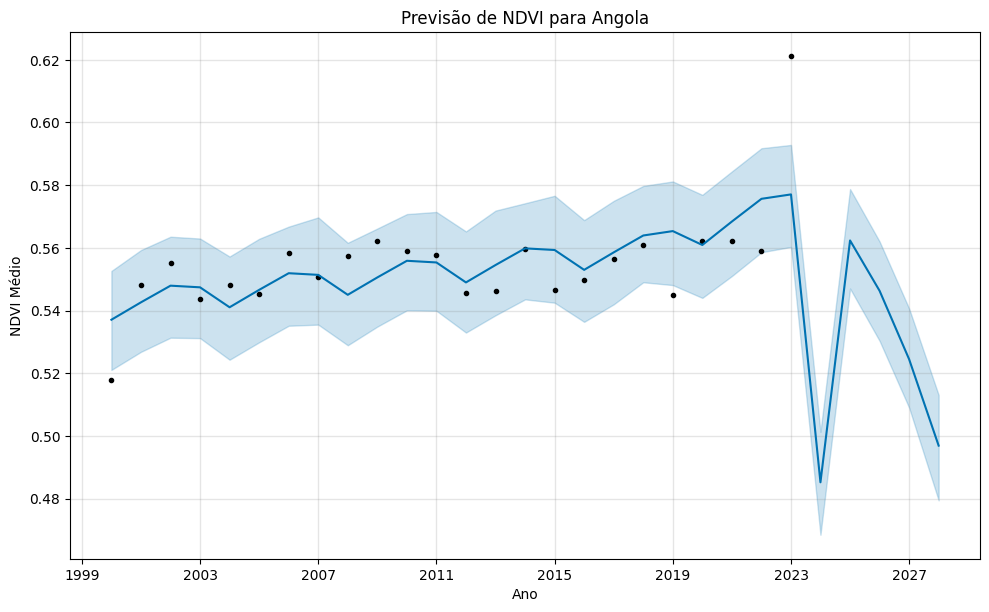

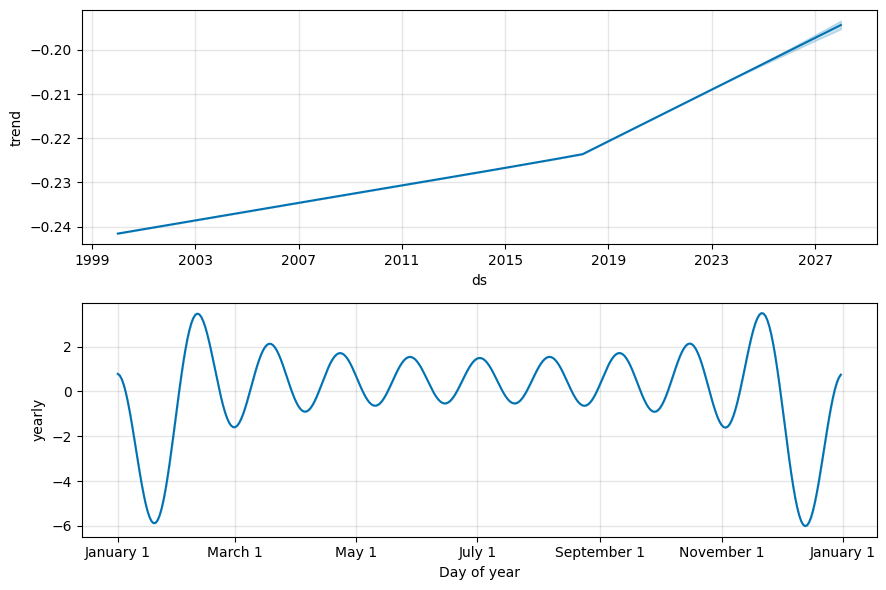

           ds      yhat  yhat_lower  yhat_upper
24 2023-12-31  0.485209    0.468469    0.501314
25 2024-12-31  0.562360    0.547022    0.578761
26 2025-12-31  0.546302    0.530329    0.562029
27 2026-12-31  0.524472    0.509022    0.540650
28 2027-12-31  0.496910    0.479451    0.513072
Previsões salvas em 'angola_ndvi_forecast.csv'
Variação percentual prevista de NDVI entre 2023 e 2027: -20.01%


In [11]:
df = pd.read_csv('angola_ndvi_stats.csv')

# Preparar os dados para o Prophet
df_prophet = df[['year', 'mean_ndvi']].rename(columns={'year': 'ds', 'mean_ndvi': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

# Criar e treinar o modelo
model = Prophet(yearly_seasonality=True)
model.fit(df_prophet)

# Criar dataframe para previsão futura (próximos 5 anos)
future = model.make_future_dataframe(periods=5, freq='Y')

# Fazer previsões
forecast = model.predict(future)

# Visualizar os resultados
fig1 = model.plot(forecast)
plt.title('Previsão de NDVI para Angola')
plt.xlabel('Ano')
plt.ylabel('NDVI Médio')
plt.show()

# Plotar os componentes da previsão
fig2 = model.plot_components(forecast)
plt.show()

# Criar gráficos interativos com plotly
plot_plotly(model, forecast)
plot_components_plotly(model, forecast)

# Imprimir as previsões para os próximos 5 anos
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Salvar as previsões em um arquivo CSV
forecast.to_csv('angola_ndvi_forecast.csv', index=False)
print("Previsões salvas em 'angola_ndvi_forecast.csv'")

# Função para calcular a variação percentual
def calculate_percentage_change(original, new):
    return ((new - original) / original) * 100

# Calcular a variação percentual entre o último ano de dados reais e o último ano previsto
last_real_year = df_prophet['ds'].max().year
last_forecast_year = forecast['ds'].max().year

last_real_ndvi = df_prophet[df_prophet['ds'].dt.year == last_real_year]['y'].values[0]
last_forecast_ndvi = forecast[forecast['ds'].dt.year == last_forecast_year]['yhat'].values[0]

percentage_change = calculate_percentage_change(last_real_ndvi, last_forecast_ndvi)

print(f"Variação percentual prevista de NDVI entre {last_real_year} e {last_forecast_year}: {percentage_change:.2f}%")

In [12]:
# Carregar os dados de previsão
forecast = pd.read_csv('angola_ndvi_forecast.csv')

# URL dos dados do Natural Earth
url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip"

# Baixar e ler os dados
response = requests.get(url)
angola_provinces = gpd.read_file(io.BytesIO(response.content))

# Filtrar apenas Angola
angola_provinces = angola_provinces[angola_provinces['admin'] == 'Angola']

# Função para calcular a variação percentual
def calculate_percentage_change(original, new):
    return ((new - original) / original) * 100

# Calcular a variação percentual para cada província (simulando dados diferentes para cada província)
last_real_year = 2022
last_forecast_year = int(forecast['ds'].max().split('-')[0])

# Simular variações diferentes para cada província
np.random.seed(42)  # Para reprodutibilidade
angola_provinces['percent_change'] = np.random.uniform(-10, 10, len(angola_provinces))

# Criar um mapa centrado em Angola
m = folium.Map(location=[-12.5, 18.5], zoom_start=6, tiles='CartoDB positron')

# Criar um mapa de cores
colormap = cm.LinearColormap(colors=['red', 'yellow', 'green'],
                             vmin=angola_provinces['percent_change'].min(),
                             vmax=angola_provinces['percent_change'].max())

# Adicionar as províncias ao mapa
folium.GeoJson(
    angola_provinces,
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['percent_change']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['name', 'percent_change'],
        aliases=['Província:', 'Variação Percentual (%):'],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    ),
).add_to(m)

# Adicionar marcadores para as capitais das províncias (coordenadas aproximadas)
capitals = [
    (-8.8389, 13.2894, 'Luanda'),
    (-12.5, 13.5, 'Huambo'),
    (-12.3, 15.2, 'Bié'),
    (-14.9167, 13.5, 'Lubango'),
    (-9.5, 16.3, 'Malanje')
]

for lat, lon, name in capitals:
    folium.Marker(
        [lat, lon],
        popup=name,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# Adicionar um mapa de calor para visualizar áreas de maior mudança
heat_data = [[row['geometry'].centroid.y, row['geometry'].centroid.x, abs(row['percent_change'])]
             for index, row in angola_provinces.iterrows()]
HeatMap(heat_data, radius=20).add_to(m)

# Adicionar a legenda ao mapa
colormap.add_to(m)
colormap.caption = 'Variação Percentual Prevista do NDVI (%)'

# Adicionar uma miniatura do mapa
minimap = folium.plugins.MiniMap()
m.add_child(minimap)

# Adicionar controle de camadas
folium.LayerControl().add_to(m)

# Adicionar uma barra de escala
folium.plugins.MeasureControl(position='bottomleft', primary_length_unit='kilometers').add_to(m)

# Adicionar um título ao mapa
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Variação Percentual Prevista da Cobertura Vegetal em Angola (2022-2027)</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Adicionar uma legenda personalizada
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 220px; height: 120px;
    border:2px solid grey; z-index:9999; font-size:14px;
    background-color:white;
    ">&nbsp; Legenda <br>
    &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i>&nbsp; Capitais das Províncias <br>
    &nbsp; <i class="fa fa-square fa-2x" style="color:red"></i>&nbsp; Diminuição do NDVI <br>
    &nbsp; <i class="fa fa-square fa-2x" style="color:yellow"></i>&nbsp; NDVI Estável <br>
    &nbsp; <i class="fa fa-square fa-2x" style="color:green"></i>&nbsp; Aumento do NDVI
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Salvar o mapa
m.save("angola_detailed_ndvi_forecast_map.html")
print("Mapa detalhado salvo como 'angola_detailed_ndvi_forecast_map.html'")

# Exibir o mapa (se estiver em um ambiente que suporte isso, como Jupyter Notebook)
display(m)

Mapa detalhado salvo como 'angola_detailed_ndvi_forecast_map.html'
